# Krill Growth Potential (KGP) + Sea Surface Temperature (SST) - 2090
- Plot Growth season (ONDJFM) integrated KGP from CESM2-LE and SST summer mean files
- Needs to load CESM timeseries
- Notebook by Alice DuVivier (NCAR)
- February 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Read in MARBL data

### Load the CESM2-LE sea ice zone data

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [7]:
# load SIZ
file_in = 'CESM2-LE-SIZ.nc'
ds_siz = xr.open_dataset(path_in+file_in, decode_times=True)

### Load the CESM2-LE MARBL data and mask by SIZ

In [8]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [9]:
# load variable
file_in = 'CESM2-LE-seasonal-integrals-KGP.nc'
ds_in = xr.open_dataset(path_in+file_in, decode_times=True)

In [10]:
# use entire growth season
data = ds_in.KGP_ONDJFM

In [11]:
# keep only points in the SIZ by year and member
data_mask = data.where(ds_siz.SIZ_SEP == 1)

In [12]:
# get ensemble mean
data_mean = data_mask.mean(dim='member_id')

# replace missing values with 0
data_mean = data_mean.fillna(0)

### Calculate mean for 2090s only

In [13]:
# choose decade
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

In [14]:
# subset data by year
temp = data_mean.isel(time=data_mean.time.isin([yy]))

# take mean over those years
data_mean = temp.mean(dim='time')

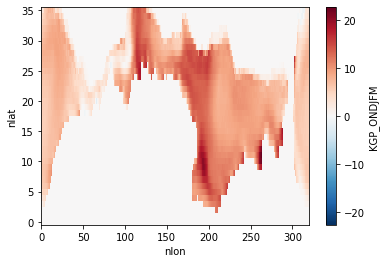

In [15]:
data_mean.plot()

In [16]:
units = ds_in.KGP_ONDJFM.units

### Load the SST Data
 - Can choose March or all Summer

In [17]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [18]:
# Read in cesm2-le  data
file_in = 'CESM2-LE-summer-mean-SST.nc'
ds_in = xr.open_mfdataset(dir_in+file_in,decode_times=False)

ds_in

<xarray.Dataset>
Dimensions:                        (time: 150, member_id: 50, nlat: 36, nlon: 320)
Coordinates:
  * time                           (time) int64 1950 1951 1952 ... 2098 2099
    SST_MAR                        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(150, 50, 36, 320), meta=np.ndarray>
    TLONG                          (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT                           (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * nlat                           (nlat) int64 0 1 2 3 4 5 ... 31 32 33 34 35
  * nlon                           (nlon) int64 0 1 2 3 4 ... 316 317 318 319
    TAREA                          (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    SST_ONDJFM                     (time, member_id, nlat, nlon) float64 dask.array<chunksize=(150, 50, 36, 320), meta=np.ndarray>
Dimensions without coordinates: member_id
Data variables:
    __xarray_dataarray_variable__  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(150, 50, 36, 320), meta=np.ndarray>

In [19]:
# keep the variable of interest only
data = ds_in.SST_MAR

In [20]:
# reassign nlat and nlon for later
data['nlat'] = ds_grid.nlat
data['nlon'] = ds_grid.nlon

## Calculate SST decadal averages

In [21]:
# specify some arrays that will become coordinate arrays
decades = list(range(1960,2100,10))
decade_names = ['1960','1970','1980','1990','2000','2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [22]:
# get dimensions of the grid we need to iterate over
xlen = len(ds_in.nlon)
ylen = len(ds_in.nlat)
dlen = len(decades)
print(xlen,ylen,dlen)

320 36 14


In [23]:
# Loop through decades

# make numpy array to fill and specify dimensions
array_decadal_all = np.zeros([dlen,ylen,xlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset
    temp1 = data.where((data.time >= yy_st)&(data.time < yy_ed),drop=True)
    # calculate mean over time
    temp2 = temp1.mean(dim='time')
    # get ensemble mean
    array_decadal_all[count,:,:] = temp2.mean(dim='member_id')

# convert to xarray
sst_dec = xr.DataArray(array_decadal_all,dims=('decades','nlat','nlon'))
sst_dec['decades'] = decades
sst_dec['nlat'] = ds_grid.nlat
sst_dec['nlon'] = ds_grid.nlon

Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [24]:
sst_mean = sst_dec.sel(decades=2090)

### Load regional mask data and shapefiles

In [25]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [26]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [27]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [28]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [29]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [30]:
# mask to omit land points
data_mean = data_mean.where(ds_grid.REGION_MASK == 1)
sst_mean = sst_mean.where(ds_grid.REGION_MASK ==1)

In [31]:
# mask where kgp = 0 because that's out of the SIZ
data_mean = data_mean.where(data_mean >0)

### Set plotting ranges, etc.

In [32]:
print(data_mean.max(dim=['nlat','nlon']))

<xarray.DataArray 'KGP_ONDJFM' ()>
dask.array<nanmax-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


In [39]:
# set some plotting info
cmap_in = cmocean.cm.amp
vmin_in = 0.0
vmax_in = 25.0
levels_in_poly = np.arange(0,3,1)
levels_in_ctr = np.arange(0,3,1)
levels_in_sst = np.arange(-2,5,1)
title = 'Growing season (ONDJFM) total KGP'

### Save plot

In [40]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_4/'
fout = 'Figure_3_KGP_SST_2090'

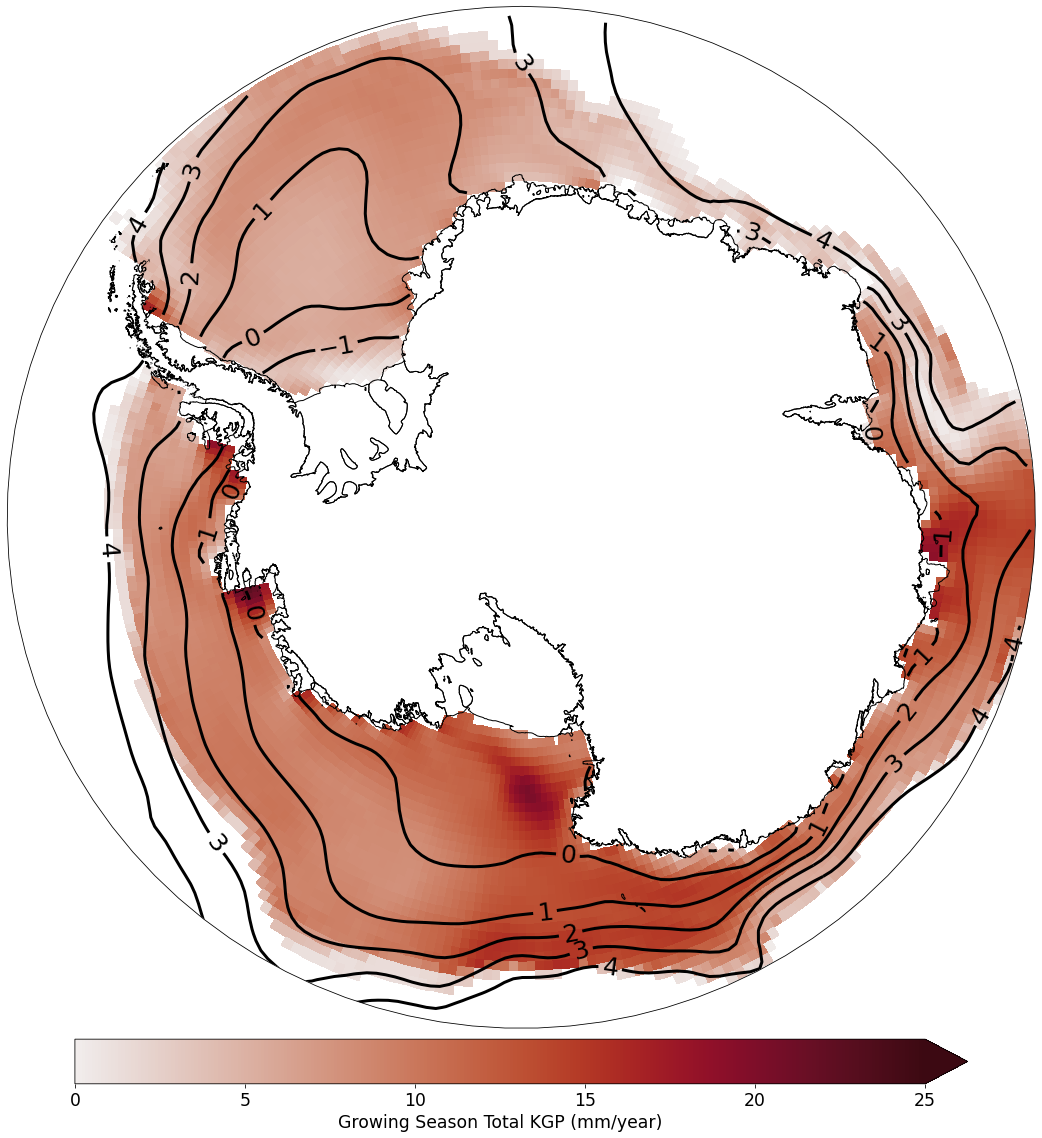

In [44]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Growing Season Total KGP ('+units+')',fontsize='xx-large')

### Overlay March SST
lon, lat, field = utils.adjust_pop_grid(lons,lats,sst_mean)
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=3,
                 levels=levels_in_sst,
                 transform=ccrs.PlateCarree())
ax.clabel(this2, inline=True, fontsize=25)

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)